# Analysis Outline:

In this project Corpus text file is analyzed. Preprocessing of text data involves transforming raw data into an understandable format for NLP models. 
1. Data cleaning and changing all the text content to lower case.
2. Tokenization to  break a stream of text into words, phrases, symbols, or other meaningful elements called tokens. The list of tokens becomes input for further processing.
3. Word Lemmatization to reduce the inflectional forms of each word into a common base or root, as well as to remove Stop words.
4. Splitting data into Train and Test datasets
5. Encoding labels to transform Categorical data of string type in the data set into numerical values which the model can understand.
6. Word Vectorization to turn a collection of text documents into numerical feature vectors
7. Fitting SVM algorithm and optimizing the hyper parameters
8. Fitting ANN algorithm and model optimization


In [117]:
import pandas as pd
import numpy as np

import nltk
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet as wn

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import model_selection, naive_bayes, svm
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from keras import regularizers
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier

import matplotlib.pyplot as plt

from collections import defaultdict

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Taraneh\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Taraneh\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Taraneh\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Taraneh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [109]:
print(tf.__version__)

2.0.0


In [3]:
np.random.seed(500)

In [5]:
Corpus = pd.read_csv("corpus.csv",encoding='latin-1')

In [7]:
Corpus

,text,label
0,Stuning even for the non-gamer: This sound tr...,__label__2
1,The best soundtrack ever to anything.: I'm re...,__label__2
2,Amazing!: This soundtrack is my favorite musi...,__label__2
3,Excellent Soundtrack: I truly like this sound...,__label__2
4,"Remember, Pull Your Jaw Off The Floor After H...",__label__2
...,...,...
9995,A revelation of life in small town America in...,__label__2
9996,Great biography of a very interesting journal...,__label__2
9997,Interesting Subject; Poor Presentation: You'd...,__label__1
9998,Don't buy: The box looked used and it is obvi...,__label__1


In [13]:
#Checking if there is any blank rows
Corpus.isna().sum()

text     0
label    0
dtype: int64

In [211]:
Corpus.label.nunique()

2

In [20]:
Corpus.dtypes

text     object
label    object
dtype: object

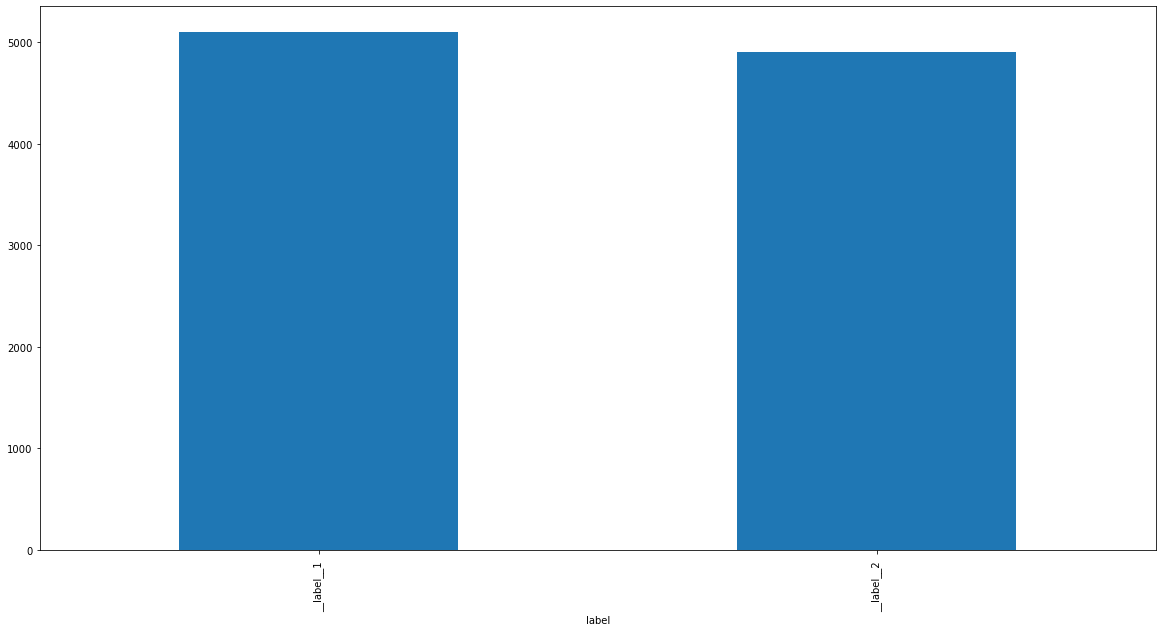

In [210]:
Corpus.groupby('label').text.count().plot(kind='bar',stacked=True, figsize=(20,10))

Based on the graph above, our data set is very balanced.

In [21]:
#Change all the text to lower case
Corpus = Corpus.applymap(lambda s:s.lower())

In [53]:
#Tokenization : In this each entry in the corpus will be broken into set of words
Corpus['text']= [word_tokenize(entry) for entry in Corpus['text']]

In [63]:
# Remove Stop words and perfom Word Stemming/Lemmenting.
# WordNetLemmatizer requires Pos tags to understand if the word is noun or verb or adjective etc. By default it is set to Noun
tag_map = defaultdict(lambda : wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV

for index,entry in enumerate(Corpus['text']):
    # Declaring Empty List to store the words that follow the rules for this step
    Final_words = []
    # Initializing WordNetLemmatizer()
    word_Lemmatized = WordNetLemmatizer()
    # pos_tag function below will provide the 'tag' i.e if the word is Noun(N) or Verb(V) or something else.
    for word, tag in pos_tag(entry):
        # Below condition is to check for Stop words and consider only alphabets
        if word not in stopwords.words('english') and word.isalpha():
            word_Final = word_Lemmatized.lemmatize(word,tag_map[tag[0]])
            Final_words.append(word_Final)
    # The final processed set of words for each iteration will be stored in 'text_final'
    Corpus.loc[index,'text_final'] = str(Final_words)

In [209]:
Corpus

,text,label,text_final
0,"[stuning, even, for, the, non-gamer, :, this, ...",__label__2,"['stun', 'even', 'sound', 'track', 'beautiful'..."
1,"[the, best, soundtrack, ever, to, anything, .,...",__label__2,"['best', 'soundtrack', 'ever', 'anything', 're..."
2,"[amazing, !, :, this, soundtrack, is, my, favo...",__label__2,"['amaze', 'soundtrack', 'favorite', 'music', '..."
3,"[excellent, soundtrack, :, i, truly, like, thi...",__label__2,"['excellent', 'soundtrack', 'truly', 'like', '..."
4,"[remember, ,, pull, your, jaw, off, the, floor...",__label__2,"['remember', 'pull', 'jaw', 'floor', 'hear', '..."
...,...,...,...
9995,"[a, revelation, of, life, in, small, town, ame...",__label__2,"['revelation', 'life', 'small', 'town', 'ameri..."
9996,"[great, biography, of, a, very, interesting, j...",__label__2,"['great', 'biography', 'interesting', 'journal..."
9997,"[interesting, subject, ;, poor, presentation, ...",__label__1,"['interest', 'subject', 'poor', 'presentation'..."
9998,"[do, n't, buy, :, the, box, looked, used, and,...",__label__1,"['buy', 'box', 'look', 'use', 'obviously', 'ne..."


### Prepare Test and Train Datasets

In [65]:
Train_X, Test_X, Train_Y, Test_Y = model_selection.train_test_split(Corpus['text_final'],Corpus['label'],test_size=0.3)

# 5. Encoding
Label encode the target variable — This is done to transform Categorical data of string type in the data set into numerical values which the model can understand.

In [66]:
Encoder = LabelEncoder()
Train_Y = Encoder.fit_transform(Train_Y)
Test_Y = Encoder.fit_transform(Test_Y)

# 6. Word Vectorization

In [67]:
# It is better to tokenize based on Frequency instead of occurance since a word might be used many times in a few long documents
# To avoid this issue, the number of occurrences of each word in a document is divided by the total number of words in the document tf for Term Frequencies
tfidf_transformer = TfidfTransformer()
Tfidf_vect = TfidfVectorizer(max_features=5000)
Tfidf_vect.fit(Corpus['text_final'])
Train_X_Tfidf = Tfidf_vect.transform(Train_X)
Test_X_Tfidf = Tfidf_vect.transform(Test_X)

In [213]:
print(Tfidf_vect.vocabulary_)

{'stun': 4271, 'even': 1529, 'sound': 4116, 'track': 4556, 'beautiful': 387, 'paint': 3160, 'mind': 2839, 'well': 4865, 'would': 4951, 'recomend': 3598, 'people': 3225, 'hate': 2054, 'video': 4763, 'game': 1855, 'music': 2925, 'play': 3298, 'cross': 1032, 'ever': 1533, 'best': 427, 'back': 330, 'away': 320, 'crude': 1035, 'take': 4371, 'fresh': 1812, 'step': 4210, 'guitar': 2004, 'soulful': 4113, 'orchestra': 3101, 'impress': 2245, 'anyone': 203, 'care': 645, 'listen': 2611, 'soundtrack': 4118, 'anything': 204, 'read': 3564, 'lot': 2655, 'review': 3721, 'say': 3840, 'figure': 1694, 'write': 4957, 'disagree': 1238, 'bit': 449, 'ultimate': 4633, 'masterpiece': 2756, 'timeless': 4506, 'year': 4976, 'beauty': 389, 'simply': 4011, 'refuse': 3621, 'price': 3407, 'tag': 4370, 'pretty': 3402, 'must': 2931, 'go': 1927, 'buy': 604, 'cd': 676, 'much': 2916, 'money': 2878, 'one': 3079, 'feel': 1671, 'worth': 4947, 'every': 1535, 'penny': 3224, 'amaze': 152, 'favorite': 1660, 'time': 4505, 'hand': 

In [216]:
print(Train_X_Tfidf) # each row shows 1: Row number of ‘Train_X_Tfidf’, 2: Unique Integer number of each word in the first row, 3: Score calculated by TF-IDF Vectorizer

  (0, 240)	0.2448559358109696
  (0, 491)	0.12303572865008613
  (0, 521)	0.321056290554803
  (0, 1529)	0.17761496997588844
  (0, 1935)	0.13406125327954532
  (0, 2931)	0.229683025366997
  (0, 3564)	0.29449641491430995
  (0, 3655)	0.2896999547088821
  (0, 3745)	0.34695623926050195
  (0, 3860)	0.2690675584422277
  (0, 3890)	0.2515140235472667
  (0, 3976)	0.35868777245753825
  (0, 4505)	0.15031494427382475
  (0, 4506)	0.3763188267807246
  (1, 604)	0.1614401835472762
  (1, 1260)	0.2074693534878867
  (1, 2592)	0.2173336717856602
  (1, 3313)	0.8157357261127677
  (1, 3434)	0.21279175847748263
  (1, 4060)	0.3566872275481094
  (1, 4687)	0.21384275526442909
  (2, 33)	0.20930831028858776
  (2, 361)	0.17411748468635024
  (2, 391)	0.13891513600828057
  (2, 499)	0.23040114109066645
  :	:
  (6998, 3496)	0.10451353633683101
  (6998, 3564)	0.288726350970047
  (6998, 3602)	0.1798213211550688
  (6998, 3686)	0.15400280027565427
  (6998, 3805)	0.1514288179316596
  (6998, 3928)	0.16387843435044955
  (6998, 41

# 7. Fitting SVM Algotithm and optimizing the hyper parameters

In [70]:
# Classifier - SVM
# fit the training data on the classifier
SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
SVM.fit(Train_X_Tfidf,Train_Y)
# predict the labels on validation dataset
predictions_SVM = SVM.predict(Test_X_Tfidf)
# Use accuracy_score function to get the accuracy
print("SVM Accuracy Score -> ",accuracy_score(predictions_SVM, Test_Y)*100)

SVM Accuracy Score ->  84.66666666666667


In [95]:
# Grid Search to find the best hyper parameters (assumption: kernel='rbf')
def svc_param_selection(X, y, nfolds):
    C = [0.001, 0.01, 0.1, 1, 10]
    gamma = [0.001, 0.01, 0.1, 1]
    param_grid = {'C': C, 'gamma' : gamma}
    
    grid_search = GridSearchCV(svm.SVC(kernel='rbf'), param_grid, cv=nfolds)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_

In [96]:
svc_param_selection(Train_X_Tfidf,Train_Y, 10) # optimized hyper parameters when kernel='rbf'

{'C': 1, 'gamma': 1}

In [97]:
# Checking the accuracy of SVM model with optimized hyper parameters and kernel='rbf'
SVM = svm.SVC(C=1.0, kernel='rbf', gamma=1.0)
SVM.fit(Train_X_Tfidf,Train_Y)
# predict the labels on validation dataset
predictions_SVM = SVM.predict(Test_X_Tfidf)
# Use accuracy_score function to get the accuracy
print("SVM Accuracy Score -> ",accuracy_score(predictions_SVM, Test_Y)*100)

SVM Accuracy Score ->  85.0


In [98]:
# Grid Search to find the best hyper parameters (assumption: kernel='linear')
def svc_param_selection(X, y, nfolds):
    C = [0.001, 0.01, 0.1, 1, 10]
    gamma = [0.001, 0.01, 0.1, 1]
    param_grid = {'C': C, 'gamma' : gamma}
    
    grid_search = GridSearchCV(svm.SVC(kernel='linear'), param_grid, cv=nfolds)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_

In [99]:
svc_param_selection(Train_X_Tfidf,Train_Y, 10) # optimized hyper parameters when kernel='linear'

{'C': 1, 'gamma': 0.001}

In [166]:
# Checking the accuracy of SVM model with optimized hyper parameters and kernel='linear'
SVM = svm.SVC(C=1.0, kernel='linear', gamma=0.001)
SVM.fit(Train_X_Tfidf,Train_Y)
# predict the labels on validation dataset
predictions_SVM = SVM.predict(Test_X_Tfidf)
# Use accuracy_score function to get the accuracy
print("SVM Accuracy Score -> ",accuracy_score(predictions_SVM, Test_Y)*100)

SVM Accuracy Score ->  84.66666666666667


In [222]:
# optimizing the min number of training data
def create_model(train_size=2000):
    train_sizes, train_scores, valid_scores = learning_curve(SVC(C=1.0, kernel='rbf', gamma=1.0), Train_X_Tfidf, Train_Y, train_sizes=train_size, cv=5)
    return train_sizes, train_scores, valid_scores

train_size=[2000,3000, 4000, 5000]

history=create_model(train_size)

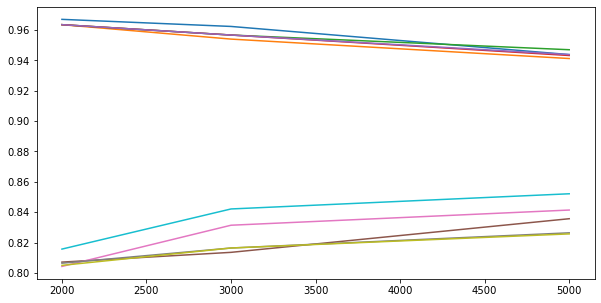

In [223]:
plt.figure(figsize=(10,5))
plt.plot(train_sizes, train_scores,train_sizes, valid_scores)

In [224]:
train_scores

array([[0.967     , 0.9635    , 0.9635    , 0.9635    , 0.9635    ],
       [0.96233333, 0.954     , 0.95666667, 0.95666667, 0.95666667],
       [0.9438    , 0.9412    , 0.947     , 0.9432    , 0.9438    ]])

In [225]:
valid_scores

array([[0.80714286, 0.80428571, 0.80642857, 0.805     , 0.81571429],
       [0.81357143, 0.83142857, 0.81642857, 0.81642857, 0.84214286],
       [0.83571429, 0.84142857, 0.82642857, 0.82571429, 0.85214286]])

Based on the above graph and results, having more than 3000 training data helps us to improve validation score and decrease the overfitting. As we increase training data size, the validation score improve and training score decreases.

# 8. Fitting ANN Algorithm and optimization

In [260]:
vocab_size = 5000
embedding_dim = 16
max_length = 120
trunc_type='post'
oov_tok='<OOV>'

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(Train_X)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(Train_X)
padded = pad_sequences(sequences, maxlen=max_length, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(Test_X)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, truncating=trunc_type)

In [261]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_20 (Embedding)     (None, 120, 16)           80000     
_________________________________________________________________
global_average_pooling1d_20  (None, 16)                0         
_________________________________________________________________
dense_40 (Dense)             (None, 6)                 102       
_________________________________________________________________
dense_41 (Dense)             (None, 1)                 7         
Total params: 80,109
Trainable params: 80,109
Non-trainable params: 0
_________________________________________________________________


In [262]:
num_epochs = 20
history = model.fit(padded, Train_Y, epochs=num_epochs, validation_data=(testing_padded, Test_Y))


Train on 7000 samples, validate on 3000 samples
Epoch 1/20
7000/7000 [==============================] - 1s 169us/sample - loss: 0.6875 - accuracy: 0.6361 - val_loss: 0.6774 - val_accuracy: 0.7387
Epoch 2/20
7000/7000 [==============================] - 1s 103us/sample - loss: 0.6450 - accuracy: 0.7881 - val_loss: 0.6036 - val_accuracy: 0.7783
Epoch 3/20
7000/7000 [==============================] - 1s 98us/sample - loss: 0.5065 - accuracy: 0.8457 - val_loss: 0.4601 - val_accuracy: 0.8360
Epoch 4/20
7000/7000 [==============================] - 1s 107us/sample - loss: 0.3750 - accuracy: 0.8757 - val_loss: 0.3970 - val_accuracy: 0.8320
Epoch 5/20
7000/7000 [==============================] - 1s 103us/sample - loss: 0.3047 - accuracy: 0.8964 - val_loss: 0.3584 - val_accuracy: 0.8557
Epoch 6/20
7000/7000 [==============================] - 1s 99us/sample - loss: 0.2612 - accuracy: 0.9103 - val_loss: 0.3458 - val_accuracy: 0.8547
Epoch 7/20
7000/7000 [==============================] - 1s 110us/s

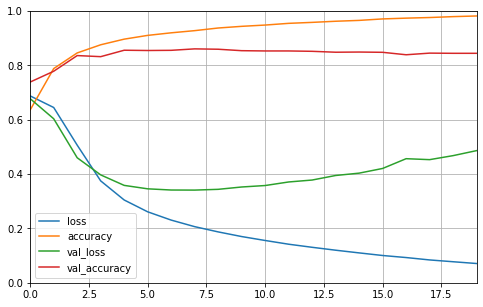

In [263]:
#Plot loss and accuracy of model for each epoch
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

The graph above clearly shows that the model is overfitting the training data. There are several ways to avoid overfitting such as adding regualizers and decreasing the network size. Also adding more training data can help to have a higher accuracy for validation data. These parameters were changed several times and following is one of the good results.

In [395]:
# Increasing vocab size, max_length, and adding drop out layers in ANN
vocab_size = 40000
embedding_dim = 16
max_length = 200
trunc_type='post'
oov_tok='<OOV>'

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(Train_X)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(Train_X)
padded = pad_sequences(sequences, maxlen=max_length, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(Test_X)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, truncating=trunc_type)

In [396]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dropout(0.7),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_53 (Embedding)     (None, 200, 16)           640000    
_________________________________________________________________
global_average_pooling1d_53  (None, 16)                0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_100 (Dense)            (None, 6)                 102       
_________________________________________________________________
dropout_19 (Dropout)         (None, 6)                 0         
_________________________________________________________________
dense_101 (Dense)            (None, 1)                 7         
Total params: 640,109
Trainable params: 640,109
Non-trainable params: 0
_______________________________________________

In [397]:
num_epochs = 20
history = model.fit(padded, Train_Y, epochs=num_epochs, validation_data=(testing_padded, Test_Y))

Train on 7000 samples, validate on 3000 samples
Epoch 1/20
7000/7000 [==============================] - 3s 473us/sample - loss: 0.6933 - accuracy: 0.5043 - val_loss: 0.6922 - val_accuracy: 0.6920
Epoch 2/20
7000/7000 [==============================] - 3s 374us/sample - loss: 0.6908 - accuracy: 0.5226 - val_loss: 0.6885 - val_accuracy: 0.5357
Epoch 3/20
7000/7000 [==============================] - 3s 377us/sample - loss: 0.6862 - accuracy: 0.5607 - val_loss: 0.6809 - val_accuracy: 0.5480
Epoch 4/20
7000/7000 [==============================] - 3s 380us/sample - loss: 0.6710 - accuracy: 0.6127 - val_loss: 0.6580 - val_accuracy: 0.5963
Epoch 5/20
7000/7000 [==============================] - 3s 379us/sample - loss: 0.6299 - accuracy: 0.6866 - val_loss: 0.6009 - val_accuracy: 0.7533
Epoch 6/20
7000/7000 [==============================] - 3s 380us/sample - loss: 0.5679 - accuracy: 0.7567 - val_loss: 0.5333 - val_accuracy: 0.7940
Epoch 7/20
7000/7000 [==============================] - 3s 414us

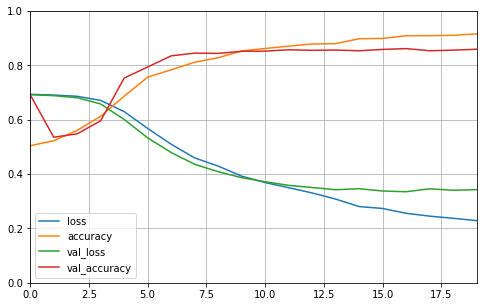

In [398]:
#Plot loss and accuracy of model for each epoch
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

We can see that the distance between accuracy and loss values of training and validation data have decreased which means that overfitting has been decreased. 